/home/aadityasp/Aditya/Projects/FAI_prjt/fai/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Generation: 0 Score: -100.07884285899841
Generation: 1 Score: -99.43141599802453
Generation: 2 Score: -100.12341952465209
Generation: 3 Score: -96.71923987511293
Generation: 4 Score: -99.11920166116651
Generation: 5 Score: -98.95568178070114
Generation: 6 Score: -98.9472662677985
Generation: 7 Score: -98.98570558711113
Generation: 8 Score: -88.14688111204111
Generation: 9 Score: -88.2564762022554
Generation: 10 Score: -84.7208348704939
Generation: 11 Score: -83.80718462162089
Generation: 12 Score: -79.73696266731592
Generation: 13 Score: -77.8271554940249
Generation: 14 Score: -71.55715705891731
Generation: 15 Score: -74.19425704477463
Generation: 16 Score: -70.60125692234821
Generation: 17 Score: -72.81263517808607
Generation: 18 Score: -73.39610933036901
Generation: 19 Score: -72.62448989932314
Generation: 20 Score: -60.17841102360952
Generation: 21 Score: -50.83967177233018
Generation: 22 Score: -53.079412155855096
Generation: 23 Score: -43.02773522030149
Generation: 24 Score: -52.4

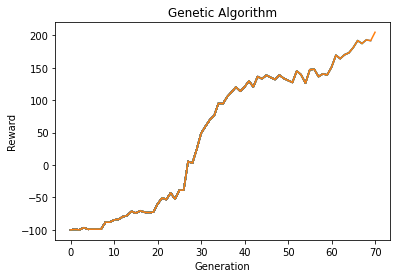

Generation: 71 Score: 204.5231520498297


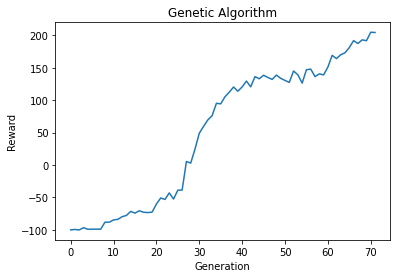

Generation: 72 Score: 204.43940255886437


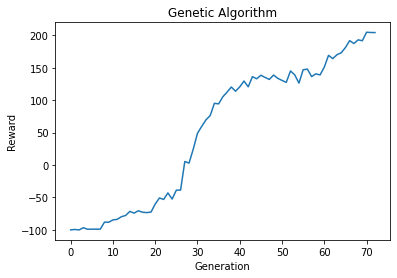

Generation: 73 Score: 205.4166294884083


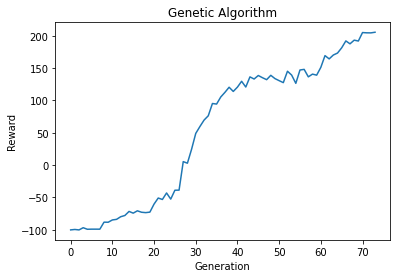

Generation: 74 Score: 203.8942564385578


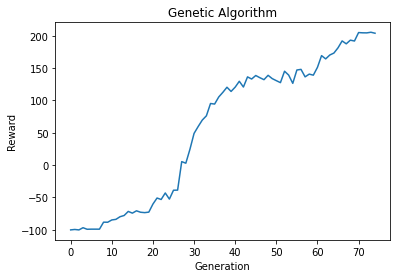

Generation: 75 Score: 200.33575044396534


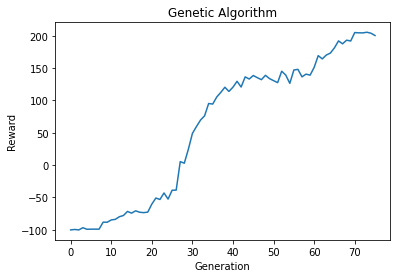

Generation: 76 Score: 206.2069445875879


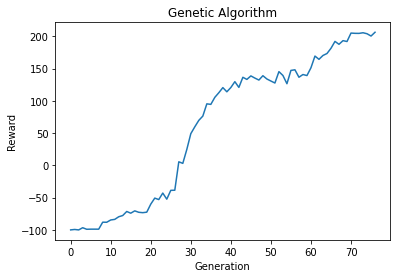

Generation: 77 Score: 197.0496838699314


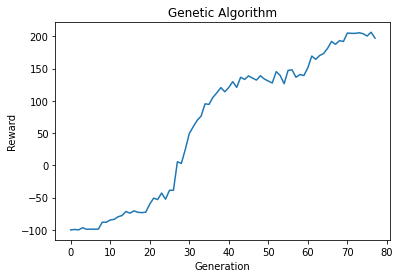

Generation: 78 Score: 208.93788318464343


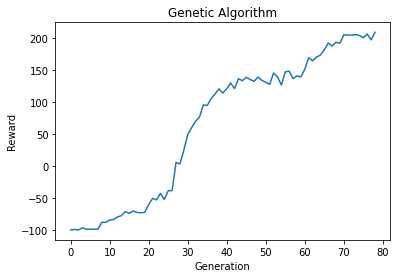

Generation: 79 Score: 195.39179946800155


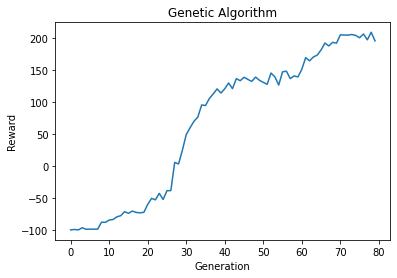

PermissionError: [Errno 13] Permission denied: '/monitor_output'

In [1]:

import gym
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
#weight initializations
#uniform_distribution
#he_init(uniform and normal)
#Xavier/glorot_distribution(normal and uniform)

def glorot_uniform(n_inputs,n_outputs,multiplier=1.0):
    ''' Glorot uniform initialization '''
    glorot = multiplier*np.sqrt(6.0/(n_inputs+n_outputs))
    #Xavier_uniform
    return np.random.uniform(-glorot,glorot,size=(n_inputs,n_outputs))

def softmax(scores,temp=5.0): #normalized exponential function with temperature scaling to prevent overly confident prob. for high value scores.
    ''' transforms scores to probabilites '''
    exp = np.exp(np.array(scores)/temp)
    return exp/exp.sum()

class Agent(object):
    ''' A Neural Network '''
    #Activation= Tanh
    def __init__(self, n_inputs, n_hidden, n_outputs, mutate_rate=.05, init_multiplier=1.0):
        ''' Create agent's brain '''
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.mutate_rate = mutate_rate
        self.init_multiplier = init_multiplier
        self.network = {'Layer 1' : glorot_uniform(n_inputs, n_hidden,init_multiplier), #(25,512)
                        'Bias 1'  : np.zeros((1,n_hidden)),
                        'Layer 2' : glorot_uniform(n_hidden, n_outputs,init_multiplier), #(512,4)
                        'Bias 2'  : np.zeros((1,n_outputs))}
                        
    def act(self, state):
        ''' Use the network to decide on an action '''        
        if(state.shape[0] != 1):
            state = state.reshape(1,-1)
        net = self.network
        layer_one = np.tanh(np.matmul(state,net['Layer 1']) + net['Bias 1'])
        layer_two = np.tanh(np.matmul(layer_one, net['Layer 2']) + net['Bias 2'])
        return layer_two[0]
    
    def __add__(self, another):
        ''' overloads the + operator for breeding '''
        child = Agent(self.n_inputs, self.n_hidden, self.n_outputs, self.mutate_rate, self.init_multiplier)
        for key in child.network:
            n_inputs,n_outputs = child.network[key].shape
            mask = np.random.choice([0,1],size=child.network[key].shape,p=[.5,.5])
            random = glorot_uniform(mask.shape[0],mask.shape[1]) #random weights initialized with glorot
            child.network[key] = np.where(mask==1,self.network[key],another.network[key]) #returns indices where mask =1
            mask = np.random.choice([0,1],size=child.network[key].shape,p=[1-self.mutate_rate,self.mutate_rate]) #selects 0 with 1-mutationrate prob, 1 with mut. rate prob
            child.network[key] = np.where(mask==1,child.network[key]+random,child.network[key]) # updates child networks layers with weights=child.network[key]+random when mask 1 
        return child
    
def run_trial(env,agent,verbose=False):
    ''' an agent performs 3 episodes of the env '''
    totals = []
    for _ in range(3):
        state = env.reset()
        if verbose: env.render()
        total = 0
        done = False
        while not done:
            state, reward, done, _ = env.step(agent.act(state))
            if reward >= 100:
                env.render()
#             if verbose: env.render()
            total += reward
        totals.append(total)
    return sum(totals)/3.0

def next_generation(env,population,scores,temperature):
    ''' breeds a new generation of agents '''
    
    scores, population =  zip(*sorted(zip(scores,population),reverse=True)) #sort scores and population w.r.t. scores.
    #select the first 25% agents and mark as children 
    children = list(population[:len(population)//4])
    #fill the remaining children with the best of parents.
    #A random sample is generated from population,with probabilities returned from softmax.
    #create 2 times the size of agents remaining after 25% children are removed.
    parents = list(np.random.choice(population,size=2*(len(population)-len(children)),p=softmax(scores,temperature)))
    #Breed between 2 Agent's from the above list and add it to the children list.
    children = children + [parents[i]+parents[i+1] for i in range(0,len(parents)-1,2)]
    #run the children agents and return children agents and their scores.
    scores = [run_trial(env,agent) for agent in children]

    return children,scores


# def update_plot(graph, new_data):
#     graph.set_xdata(np.append(graph.get_xdata(), new_data[0]))
#     graph.set_ydata(np.append(graph.get_ydata(), new_data[1]))
#     plt.draw()
    
def main():
    ''' main function '''
    graph = plt.plot([],[]) 
    # Setup environment
    env = gym.make('BipedalWalker-v3')
    env.seed(0)
    np.random.seed(0)
    genlist=[]
    rewardlist=[]
    # network params
    n_inputs = env.observation_space.shape[0] # 24 observations
    n_actions = env.action_space.shape[0] # 4 actions
    n_hidden = 512 
    multiplier = 5
    
    # Population params
    pop_size = 50
    mutate_rate = .1
    softmax_temp = 5.0
    
    # Training
    n_generations = 80
    #create agents(as per population size)
    population = [Agent(n_inputs,n_hidden,n_actions,mutate_rate,multiplier) for i in range(pop_size)]
    #run all agents in the population
    scores = [run_trial(env,agent) for agent in population]
    #choose the best agent from the above trial and store it as best agent.
    best = [deepcopy(population[np.argmax(scores)])]
    #create new generation and repeat for n generations
    for generation in range(n_generations):
        #create next generation fromcurrent poulation and scores.
        population,scores = next_generation(env,population, scores,softmax_temp)
        best.append(deepcopy(population[np.argmax(scores)]))
        print( "Generation:",generation,"Score:",np.max(scores))
        genlist+=[generation]
        rewardlist+=[np.max(scores)]
        xpoints = np.array(genlist)
        ypoints = np.array(rewardlist)
        plt.plot(xpoints, ypoints)
        plt.title("Genetic Algorithm")
        plt.xlabel("Generation")
        plt.ylabel("Reward")
        if generation>= 70:
            plt.show()
        #         data= (generation, np.max(scores))
#         update_plot(graph,data)

    # Record every agent
    env = gym.wrappers.Monitor(env,'/monitor_output',force=True,video_callable=lambda episode_id: episode_id%3==0) #'/tmp/walker'   
    for agent in best:
        run_trial(env,agent)
    env.close()
    
if __name__ == '__main__':
    main()

In [ ]:
# !sudo apt-get -y install ffmpeg
!pip install matplotlib

# 80 Gens
Generation: 0 Score: -100.07884285899841
Generation: 1 Score: -99.43141599802453
Generation: 2 Score: -100.12341952465209
Generation: 3 Score: -96.71923987511293
Generation: 4 Score: -99.11920166116651
Generation: 5 Score: -98.95568178070114
Generation: 6 Score: -98.9472662677985
Generation: 7 Score: -98.98570558711113
Generation: 8 Score: -88.14688111204111
Generation: 9 Score: -88.2564762022554
Generation: 10 Score: -84.7208348704939
Generation: 11 Score: -83.80718462162089
Generation: 12 Score: -79.73696266731592
Generation: 13 Score: -77.8271554940249
Generation: 14 Score: -71.55715705891731
Generation: 15 Score: -74.19425704477463
Generation: 16 Score: -70.60125692234821
Generation: 17 Score: -72.81263517808607
Generation: 18 Score: -73.39610933036901
Generation: 19 Score: -72.62448989932314
Generation: 20 Score: -60.17841102360952
Generation: 21 Score: -50.83967177233018
Generation: 22 Score: -53.079412155855096
Generation: 23 Score: -43.02773522030149
Generation: 24 Score: -52.48782462556789
Generation: 25 Score: -38.796501585152704
Generation: 26 Score: -38.61967949881057
Generation: 27 Score: 5.4382598812903495
Generation: 28 Score: 2.9957253875354177
Generation: 29 Score: 24.56730191511257
Generation: 30 Score: 49.038023042851854
Generation: 31 Score: 59.68679280720761
Generation: 32 Score: 69.67381080529772
Generation: 33 Score: 76.25514839279117
Generation: 34 Score: 95.25026846769254
Generation: 35 Score: 94.42016510715025
Generation: 36 Score: 105.3570386195006
Generation: 37 Score: 112.51350406123315
Generation: 38 Score: 120.40496545562273
Generation: 39 Score: 113.92486149263003
Generation: 40 Score: 120.58434806004318
Generation: 41 Score: 129.60969996593101
Generation: 42 Score: 120.72116609801027
Generation: 43 Score: 136.40006060636208
Generation: 44 Score: 133.12543205231748
Generation: 45 Score: 138.53658778073353
Generation: 46 Score: 135.15193417422824
Generation: 47 Score: 132.11102839953722
Generation: 48 Score: 138.84261601353379
Generation: 49 Score: 133.75285351567712
Generation: 50 Score: 130.58514936695616
Generation: 51 Score: 127.5330201450796
Generation: 52 Score: 145.1527219184736
Generation: 53 Score: 139.21306274901224
Generation: 54 Score: 126.43323038921137
Generation: 55 Score: 147.05425802377576
Generation: 56 Score: 148.02307211698516
Generation: 57 Score: 136.47115382257505
Generation: 58 Score: 140.6853655456216
Generation: 59 Score: 139.08807396004048
Generation: 60 Score: 151.1514922793278
Generation: 61 Score: 169.27609368724424
Generation: 62 Score: 164.22981132748717
Generation: 63 Score: 170.21954864385404
Generation: 64 Score: 173.23744493530242
Generation: 65 Score: 181.33300096010953
Generation: 66 Score: 191.99886473225465
Generation: 67 Score: 187.52284173382841
Generation: 68 Score: 193.18610738116487
Generation: 69 Score: 191.84656242112987
Generation: 70 Score: 204.92281208467935
Generation: 71 Score: 204.5231520498297
Generation: 72 Score: 204.43940255886437
Generation: 73 Score: 205.4166294884083
Generation: 74 Score: 203.8942564385578
Generation: 75 Score: 200.33575044396534
Generation: 76 Score: 206.2069445875879
Generation: 77 Score: 197.0496838699314
Generation: 78 Score: 208.93788318464343
Generation: 79 Score: 195.39179946800155

In [2]:
np.random.choice([0,1],size=(25,512),p=[.5,.5])


array([[0, 0, 1, ..., 0, 1, 1],
       [0, 0, 1, ..., 0, 1, 1],
       [1, 1, 1, ..., 1, 0, 1],
       ...,
       [1, 1, 0, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 1]])

In [ ]:
Generation: 0 Score: -100.07884285899841
Generation: 1 Score: -99.43141599802453
Generation: 2 Score: -100.12341952465209
Generation: 3 Score: -96.71923987511293
Generation: 4 Score: -99.11920166116651
Generation: 5 Score: -98.95568178070114
Generation: 6 Score: -98.9472662677985
Generation: 7 Score: -98.98570558711113
Generation: 8 Score: -88.14688111204111
Generation: 9 Score: -88.2564762022554
Generation: 10 Score: -84.7208348704939
Generation: 11 Score: -83.80718462162089
Generation: 12 Score: -79.73696266731592
Generation: 13 Score: -77.8271554940249
Generation: 14 Score: -71.55715705891731
Generation: 15 Score: -74.19425704477463
Generation: 16 Score: -70.60125692234821
Generation: 17 Score: -72.81263517808607
Generation: 18 Score: -73.39610933036901
Generation: 19 Score: -72.62448989932314
Generation: 20 Score: -60.17841102360952
Generation: 21 Score: -50.83967177233018
Generation: 22 Score: -53.079412155855096
Generation: 23 Score: -43.02773522030149
Generation: 24 Score: -52.48782462556789
Generation: 25 Score: -38.796501585152704
Generation: 26 Score: -38.61967949881057
Generation: 27 Score: 5.4382598812903495
Generation: 28 Score: 2.9957253875354177
Generation: 29 Score: 24.56730191511257
Generation: 30 Score: 49.038023042851854
Generation: 31 Score: 59.68679280720761
Generation: 32 Score: 69.67381080529772
Generation: 33 Score: 76.25514839279117
Generation: 34 Score: 95.25026846769254
Generation: 35 Score: 94.42016510715025
Generation: 36 Score: 105.3570386195006
Generation: 37 Score: 112.51350406123315
Generation: 38 Score: 120.40496545562273
Generation: 39 Score: 113.92486149263003
Generation: 40 Score: 120.58434806004318
Generation: 41 Score: 129.60969996593101
Generation: 42 Score: 120.72116609801027
Generation: 43 Score: 136.40006060636208
Generation: 44 Score: 133.12543205231748
Generation: 45 Score: 138.53658778073353
Generation: 46 Score: 135.15193417422824
Generation: 47 Score: 132.11102839953722
Generation: 48 Score: 138.84261601353379
Generation: 49 Score: 133.75285351567712
Generation: 50 Score: 130.58514936695616
Generation: 51 Score: 127.5330201450796
Generation: 52 Score: 145.1527219184736
Generation: 53 Score: 139.21306274901224
Generation: 54 Score: 126.43323038921137
Generation: 55 Score: 147.05425802377576
Generation: 56 Score: 148.02307211698516
Generation: 57 Score: 136.47115382257505
Generation: 58 Score: 140.6853655456216
Generation: 59 Score: 139.08807396004048
Generation: 60 Score: 151.1514922793278
Generation: 61 Score: 169.27609368724424
Generation: 62 Score: 164.22981132748717
Generation: 63 Score: 170.21954864385404
Generation: 64 Score: 173.23744493530242
Generation: 65 Score: 181.33300096010953
Generation: 66 Score: 191.99886473225465
Generation: 67 Score: 187.52284173382841
Generation: 68 Score: 193.18610738116487
Generation: 69 Score: 191.84656242112987
Generation: 70 Score: 204.92281208467935
Generation: 71 Score: 204.5231520498297
Generation: 72 Score: 204.43940255886437
Generation: 73 Score: 205.4166294884083
Generation: 74 Score: 203.8942564385578
Generation: 75 Score: 200.33575044396534
Generation: 76 Score: 206.2069445875879
Generation: 77 Score: 197.0496838699314
Generation: 78 Score: 208.93788318464343
Generation: 79 Score: 195.39179946800155
